<a href="https://colab.research.google.com/github/ShwetaBaranwal/Transformer/blob/master/AttentionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/ShwetaBaranwal/Transformer.git

Cloning into 'Transformer'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 22 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (22/22), done.


In [0]:
import os
os.chdir('./Transformer/')

In [3]:
from config_file import config_set
from __future__ import unicode_literals
import numpy as np
from transformer import get_model, decode


Using TensorFlow backend.


In [0]:
#calling configuration class
hp = config_set()

#downloading dataset
!bash download.sh

#preprocessing dataset
!python data_load.py


In [25]:
print("Let's see how segmented data look like")
print("train1:", open("iwslt2016/segmented/train.de.bpe",'r').readline())
print("train2:", open("iwslt2016/segmented/train.en.bpe", 'r').readline())
print("eval1:", open("iwslt2016/segmented/eval.de.bpe", 'r').readline())
print("eval2:", open("iwslt2016/segmented/eval.en.bpe", 'r').readline())
print("test1:", open("iwslt2016/segmented/test.de.bpe", 'r').readline())


Let's see how segmented data look like
train1: ▁David ▁Gall o : ▁Das ▁ist ▁Bill ▁Lange . ▁Ich ▁bin ▁Dave ▁Gall o .

train2: ▁David ▁Gall o : ▁This ▁is ▁Bill ▁Lange . ▁I ' m ▁Dave ▁Gall o .

eval1: ▁Als ▁ich ▁11 ▁Jahre ▁alt ▁war , ▁wurde ▁ich ▁eines ▁Morgens ▁von ▁den ▁Kl ängen ▁h eller ▁Freude ▁gewe ckt .

eval2: ▁When ▁I ▁was ▁11, ▁I ▁remember ▁waking ▁up ▁one ▁morning ▁to ▁the ▁sound ▁of ▁joy ▁in ▁my ▁house .

test1: ▁Als ▁ich ▁in ▁meinen ▁20 ern ▁war , ▁hatte ▁ich ▁meine ▁erste ▁Psych otherapie - Pat ient in .



In [5]:
#importing sentencepiece tokenizor model
import sentencepiece as spm
sp = spm.SentencePieceProcessor()
sp.Load(hp.embed_model)


True

In [0]:
class final_data():
    """
    reads input and output document and modifies it in the form that model takes
    """

    def __init__(self, vocab_fpath, fpath1, fpath2, maxlen1, maxlen2):
      """
      :param vocab_fpath: vocabulary file path
      :param fpath1: source document (German)
      :param fpath2: target document (English)
      :param maxlen1: max sentence length of german document
      :param maxlen2: max sentence length of english document
      Returns
      Intialization
      """
      self.vocab_fpath = vocab_fpath
      self.fpath1 = fpath1
      self.fpath2 = fpath2
      self.maxlen1 = maxlen1
      self.maxlen2 = maxlen2


    def load_vocab(self, vocab_path):
      """
      Loads vocabulary file and returns idx<->token maps
      :param vocab_path: (string) vocabulary file path
      Note that these are reserved
      0: <pad>, 1: <unk>, 2: <s>, 3: </s>

      sample of vocab file:
      <pad>	0
      <unk>	0
      <s>	0
      </s>	0
      en	-0
      er	-1
      in	-2
      ▁t	-3
      ch	-4
      ▁a	-5
      ▁d	-6
      ▁w	-7
      ▁s	-8
      ▁th	-9
      nd	-10
      ie	-11

      Returns
      two dictionaries.
      """
      vocab = [line.split()[0] for line in open(vocab_path, 'r').read().splitlines()]
      token2idx = {token: idx for idx, token in enumerate(vocab)}
      idx2token = {idx: token for idx, token in enumerate(vocab)}
      return token2idx, idx2token


    def load_data(self, path1, path2, T1, T2):
      """
      Loads source and target data and filters out too lengthy samples.
      :param path1: source file path. string.
      :param path2: target file path. string.
      :param T1: source sent maximum length. scalar.
      :param T2: target sent maximum length. scalar.
      Returns
      sents1: list of source sents
      sents2: list of target sents
      """
      sents1, sents2 = [], []
      with open(path1, 'r') as f1, open(path2, 'r') as f2:
          for sent1, sent2 in zip(f1, f2):
              if len(sent1.split()) + 1 > T1: continue # 1: </s>
              if len(sent2.split()) + 1 > T2: continue  # 1: </s>
              sents1.append(sent1.strip())
              sents2.append(sent2.strip())

      return sents1, sents2


    def encode(self, inp, type, dict, T1, T2):
      """
      Converts string to number.
      :param inp: input sentence tokens
      :param type: "x" (source side) or "y" (target side)
      :param dict: token2idx dictionary
      :param T1: source sent maximum length. scalar.
      :param T2: target sent maximum length. scalar.
      Returns
      list of numbers
      """
      inp_str = str(inp)
      if type=="x":
        tokens = inp_str.split() + ["</s>"] + ['<pad>'] * (T1 - len(inp_str.split()) - 1)
      else:
        tokens = ["<s>"] + inp_str.split() + ["</s>"] + ['<pad>'] * (T2 - len(inp_str.split()) - 1)

      x = [dict.get(t, dict["<unk>"]) for t in tokens]
      return x


    def padded_array(self, sents1, sents2):
      """
      Generates training / evaluation data
      sents1: list of source sents
      sents2: list of target sents
      Returns
      encoder input
      decoder input
      decoder output
      """
      encode_input=[]
      decode_input=[]
      decode_output_=[]
      self.token2idx, self.idx2token = self.load_vocab(self.vocab_fpath)
      for sent1, sent2 in zip(sents1, sents2):
          x = self.encode(sent1, "x", self.token2idx, self.maxlen1, self.maxlen2)
          y = self.encode(sent2, "y", self.token2idx, self.maxlen1, self.maxlen2)
          decoder_inp, y = y[:-1], y[1:]
          encode_input.append(x)
          decode_input.append(decoder_inp)
          decode_output_.append(y)

      decode_output = [list(map(lambda r: [r], r)) for r in decode_output_]

      print("total lines in encoder input = {}".format(len(encode_input)))
      print("total lines in decoder input = {}".format(len(decode_input)))
      print("total lines in decoder output = {}".format(len(decode_output)))

      return encode_input, decode_input, decode_output


    def compute(self):
      """
      calls all definition in order
      """
      xs, ys = self.load_data(self.fpath1, self.fpath2, self.maxlen1, self.maxlen2)
      x, y_in, y_out = self.padded_array(xs, ys)
      return x, y_in, y_out


In [7]:
# hp.maxlen1, hp.maxlen2 = 20,20
#calling training data
m = final_data(hp.vocab, hp.train1, hp.train2, hp.maxlen1, hp.maxlen2)
x, y_in, y_out = m.compute()


total lines in encoder input = 101814
total lines in decoder input = 101814
total lines in decoder output = 101814


In [8]:
x[0]

[4416,
 13146,
 31931,
 31976,
 298,
 100,
 5101,
 20907,
 31943,
 236,
 862,
 20545,
 13146,
 31931,
 31943,
 3,
 0,
 0,
 0,
 0]

In [9]:
y_in[0]

[2,
 4416,
 13146,
 31931,
 31976,
 553,
 96,
 5101,
 20907,
 31943,
 40,
 31952,
 31937,
 20545,
 13146,
 31931,
 31943,
 3,
 0,
 0]

In [10]:
y_out[0]

[[4416],
 [13146],
 [31931],
 [31976],
 [553],
 [96],
 [5101],
 [20907],
 [31943],
 [40],
 [31952],
 [31937],
 [20545],
 [13146],
 [31931],
 [31943],
 [3],
 [0],
 [0],
 [0]]

In [18]:
print(np.array(x).shape)
print(np.array(y_in).shape)
print(np.array(y_out).shape)

(101814, 20)
(101814, 20)
(101814, 20, 1)


In [11]:
#getting model
model = get_model(
            token_num=len(m.token2idx),
            embed_dim=32,
            encoder_num=2,
            decoder_num=2,
            head_num=4,
            hidden_dim=128,
            dropout_rate=0.05,
            use_same_embed=True,  # Use different embeddings for different languages
        )

model.compile('adam', 'sparse_categorical_crossentropy')

model.summary()







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Decoder-Input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
Encoder-Input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
Token-Embedding (EmbeddingRet)  [(None, None, 32), ( 1024000     Encoder-Input[0][0]              
                                                                 Decoder-Input[0][0]              
_____________________________________________________________________

In [12]:
#model fitting
model.fit(
            x=[np.array(x), np.array(y_in)],
            y=np.array(y_out),
            epochs=10,
            batch_size=32
        )


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/10





101814/101814 [==============================] - 138s 1ms/step - loss: 4.6809
Epoch 2/10
101814/101814 [==============================] - 123s 1ms/step - loss: 3.6366
Epoch 3/10
101814/101814 [==============================] - 123s 1ms/step - loss: 3.2111
Epoch 4/10
101814/101814 [==============================] - 123s 1ms/step - loss: 2.9355
Epoch 5/10
101814/101814 [==============================] - 122s 1ms/step - loss: 2.7456
Epoch 6/10
101814/101814 [==============================] - 122s 1ms/step - loss: 2.6104
Epoch 7/10
101814/101814 [==============================] - 121s 1ms/step - loss: 2.5120
Epoch 8/10
101814/101814 [==============================] - 121s 1ms/step - loss: 2.4361
Epoch 9/10
101814/101814 [==============================] - 122s 1ms/step - loss: 2.3770
Epoch 10/10
101814/101814 [==============================] - 122s 1ms/step - loss: 2.3290


In [13]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")


Saved model to disk


In [0]:
# # load json and create model
# from keras.models import model_from_json
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")

In [14]:
#calling evaluation/validation data
m = final_data(hp.vocab, hp.eval1, hp.eval2, hp.maxlen1, hp.maxlen2)
x_eval, y_in_eval, y_out_eval = m.compute()


total lines in encoder input = 487
total lines in decoder input = 487
total lines in decoder output = 487


In [16]:
print(np.array(x_eval).shape)
print(np.array(y_in_eval).shape)
print(np.array(y_out_eval).shape)

(487, 20)
(487, 20)
(487, 20, 1)


In [17]:
#predicting
s_id, sentence, output_sentence = decode(
                                    model,
                                    x_eval,
                                    dict_token2idx = m.token2idx,
                                    dict_idx2token = m.idx2token,
                                    sp = sp
                                    )


100%|██████████| 19/19 [00:15<00:00,  1.15s/it]


In [19]:
#displaying few predicted output
for i in range(hp.sample_num_display):
    predicted = sentence[i]
    actual = ' '.join(map(lambda x: m.idx2token[x], y_in_eval[i]))
    print("predicted = {}".format(predicted))
    print("actual = {}".format(actual))
    print('\n')


predicted = <s> ▁My ▁dad ▁heard ▁to ▁be ▁on ▁his ▁little ▁bit ▁of ▁the ▁Christian ▁secret ▁program . </s> <pad> <pad> <pad>
actual = <s> ▁My ▁father ▁was ▁listening ▁to ▁BBC ▁News ▁on ▁his ▁small , ▁gray ▁radio . </s> <pad> <pad> <pad> <pad>


predicted = <s> ▁He ▁called ▁" We ' re ▁gone ▁out ." </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
actual = <s> ▁" The ▁Taliban ▁are ▁gone !" ▁my ▁father ▁sh ou ted . </s> <pad> <pad> <pad> <pad> <pad> <pad>


predicted = <s> ▁" I ▁can ▁go ▁to ▁a ▁right ▁school , ▁he ▁said , ▁he ▁said . </s> <pad> <pad> <pad>
actual = <s> ▁" You ▁can ▁go ▁to ▁a ▁real ▁school ▁now ," ▁he ▁said . </s> <pad> <pad> <pad> <pad> <pad>


predicted = <s> ▁This ▁morning ▁I ▁never ▁never ▁forgot . </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
actual = <s> ▁A ▁morning ▁that ▁I ▁will ▁never ▁forget . </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


predicted = <s> ▁You ' re ▁the ▁right ▁school . </s> <pad> <pad> <pad> <

In [0]:
#writing predicted output in file
with open(hp.predicted_output_file, "w") as fout:
    for sent in output_sentence:
        fout.write(sent + "\n")

#writing actual output in file
with open(hp.actual_output_file, "w") as fout:
    for sent in y_in_eval:
      s1 = list(map(lambda x: m.idx2token[x], sent))
      s2 = ' '.join(i.replace('▁','') for i in s1 if i not in ('<s>','</s>','<pad>'))
      fout.write(s2 + "\n")


In [21]:
#computing BLEU score for validation data
from nltk.translate.bleu_score import sentence_bleu
score = []
with open(hp.actual_output_file, 'r') as f1, open(hp.predicted_output_file, 'r') as f2:
    for actual, predict in zip(f1, f2):
        reference = actual.split()
        candidate = predict.split()
        score.append(sentence_bleu(reference, candidate))
print("Avg Bleu score for document is: {}".format(float(sum(score)/len(score))))
print("Min Bleu score for document is: {}".format(float(min(score))))
print("Max Bleu score for document is: {}".format(float(max(score))))


Avg Bleu score for document is: 0.22658467412289496
Min Bleu score for document is: 0.0
Max Bleu score for document is: 0.8408964152537145


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


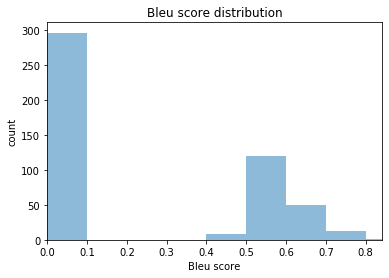

In [23]:
#plotting bleu score distribution
import random
from matplotlib import pyplot as plt

data = np.array(score)

# fixed bin size
bins = np.arange(0.0,1.0,0.1) # fixed bin size

plt.xlim([min(data), max(data)])

plt.hist(data, bins=bins, alpha=0.5)
plt.title('Bleu score distribution')
plt.xlabel('Bleu score')
plt.ylabel('count')
plt.show()


In [24]:
#calling test data
m = final_data(hp.vocab, hp.test1, hp.test1, hp.maxlen1, hp.maxlen2)
x_test, _, _ = m.compute()

#predicting
s_id_test, sentence_test, output_sentence_test = decode(
                                          model,
                                          x_test,
                                          dict_token2idx = m.token2idx,
                                          dict_idx2token = m.idx2token,
                                          sp = sp
                                          )

#writing predicted output in file
with open(hp.test_output_file, "w") as fout:
    for sent in output_sentence_test:
        fout.write(sent + "\n")


  0%|          | 0/19 [00:00<?, ?it/s]

total lines in encoder input = 724
total lines in decoder input = 724
total lines in decoder output = 724


100%|██████████| 19/19 [00:20<00:00,  1.72s/it]
